# Machine Learning in Fundamental Physics

In [1]:
import time
import tensorflow as tf
from tensorflow.python.keras import Input
from tensorflow.python.keras.engine.functional import Functional
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.models import Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
tf.compat.v1.enable_eager_execution()

## Exercise Sheet 10, Problem 2


In [2]:
class MNISTData:
    """Data class already implemented for you and ready to use."""
    def __init__(self, data_fraction=1./10):
        data = mnist
        (self.x_train, self.y_train), (self.x_test, self.y_test) = data.load_data()

        self.get_subset_of_data(data_fraction)

        self.convert_label_to_categorical()
        self.normalize_mnist_images()

        self.reshape_to_color_channel()
        self.flatten_pictures()

    # vector to matrix for eg categorical_crossentropy
    def convert_label_to_categorical(self):
        self.y_train = to_categorical(self.y_train)
        self.y_test = to_categorical(self.y_test)

    # pixel value (0,255) -> (0,1)
    def normalize_mnist_images(self):
        self.x_train = self.x_train / 255.0
        self.x_test = self.x_test / 255.0

    # add new axis for color channel
    def reshape_to_color_channel(self):
        self.x_train = self.x_train[:, :, :, np.newaxis]
        self.x_test = self.x_test[:, :, :, np.newaxis]

    def get_subset_of_data(self, data_fraction):
        index = int(len(self.x_train) * data_fraction)
        self.x_train = self.x_train[:index]
        self.y_train = self.y_train[:index]
        index = int(len(self.x_test) * data_fraction)
        self.x_test = self.x_test[:index]
        self.y_test = self.y_test[:index]

    def flatten_pictures(self):
        self.x_train = self.x_train.reshape(self.x_train.shape[0], -1)
        self.x_test = self.x_test.reshape(self.x_test.shape[0], -1)
        print("x_train, x_test shape", np.shape(self.x_train), np.shape(self.x_test))
        print("y_train, y_test shape", np.shape(self.x_train), np.shape(self.x_test))


In [3]:
class Model_without_custom_training_loop:
    def __init__(self, data: MNISTData, num_classes=10):
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test

        self.num_classes = num_classes
        self.input_shape = self.x_train[0].shape

        self.input = Input(shape=self.input_shape)
        self.output = None

        self.model = None
        self.history = None

    def build_model(self):
        "Build the model."""
        x = Dense(64, activation='relu')(self.input)
        x = Dense(64, activation='relu')(x)
        self.output = Dense(self.num_classes, activation='softmax')(x)
        self.model = Model(self.input, self.output)
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def fit_data(self, batch_size=128, epochs=20, use_latent_classifier=False):
        """Fit the data with the native Keras method. Print out the total time for the fitting"""
        
        start_time = time.time()
        self.history = self.model.fit(data.x_train, data.y_train,
                                            epochs=epochs,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            validation_data=(data.x_test, data.y_test))
        print("\nTotal time taken: %.2fs" % (time.time() - start_time))
        
        self.history = self.history.history

    def plot_score(self, model_name=None):
        """Plots the scores achieved during the fitting."""
        plt.plot(self.history['accuracy'])
        plt.plot(self.history['val_accuracy'])
        plt.ylabel('Model Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='best')
        if model_name is not None:
            plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        plt.show()


In [4]:
class Model_with_custom_training_loop:
    def __init__(self, data: MNISTData, num_classes=10):
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test
        
        self.train_dataset = None
        self.val_dataset = None

        self.num_classes = num_classes
        self.input_shape = self.x_train[0].shape

        self.input = Input(shape=self.input_shape)
        self.output = None

        self.model = None
        
        # Dictionary for plotting analogous to the keras history.
        self.history = {
                        "acc": [],
                        "val_acc": [],
                       }
        
        self.optimizer = None
        self.loss_fn = None
        
        self.train_acc_metric = None
        self.val_acc_metric = None

    def build_model(self):
        """Build the model."""
        x = Dense(64, activation='relu')(self.input)
        x = Dense(64, activation='relu')(x)
        self.output = Dense(self.num_classes, activation='softmax')(x)
        self.model = Model(self.input, self.output)
    
    def prepare_data(self, batch_size):
        """Prepare the data for the custom training loop. Will automatically be called by fit_data"""
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
        self.train_dataset = self.train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        self.val_dataset = tf.data.Dataset.from_tensor_slices((self.x_test, self.y_test))
        self.val_dataset = self.val_dataset.batch(batch_size)
    
    @tf.function
    def train_step(self, x, y):
        """Custom training step; the performance is enhanced by tf.function"""
        # Open a GradientTape, enables auto-differentiation
        with tf.GradientTape() as tape:
            # Logits for this minibatch
            logits = self.model(x, training=True)
            # Compute the loss value for this minibatch.
            loss_value = self.loss_fn(y, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        # log
        self.train_acc_metric.update_state(y, logits)
        return loss_value
    
    @tf.function
    def test_step(self, x, y):
        """Custom test step; the performance is enhanced by tf.function"""
        val_logits = self.model(x, training=False)
        self.val_acc_metric.update_state(y, val_logits)
    
    def fit_data(self, batch_size=128, epochs=20, use_latent_classifier=False):
        """Fit data and store the accuracy results in the dictionary self.history. 
        Print out the total time for the fitting"""
        self.prepare_data(batch_size)
        # Instantiate an optimizer.
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        # Instantiate a loss function.
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        
        self.train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        self.val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        
        start_time = time.time()
        
        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            start_time_epoch = time.time()

            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(self.train_dataset):
                loss_value = self.train_step(x_batch_train, y_batch_train)

                # Log every 200 batches.
                if step % 200 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * batch_size))

            # Display metrics at the end of each epoch.
            train_acc = self.train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))
            
            #Store the data for plotting
            self.history['acc'].append(train_acc)

            # Reset training metrics at the end of each epoch
            self.train_acc_metric.reset_states()

            # Run a validation loop at the end of each epoch.
            for x_batch_val, y_batch_val in self.val_dataset:
                self.test_step(x_batch_val, y_batch_val)

            val_acc = self.val_acc_metric.result()
            
            #Store the data for plotting
            self.history['val_acc'].append(val_acc)
            
            self.val_acc_metric.reset_states()
            print("Validation acc: %.4f" % (float(val_acc),))
            print("Time taken: %.2fs" % (time.time() - start_time_epoch))
            
        print("\nTotal time taken: %.2fs" % (time.time() - start_time))
        

    def plot_score(self, model_name=None):
        """Plots the scores achieved during the fitting."""
        plt.plot(self.history['acc'])
        plt.plot(self.history['val_acc'])
        plt.ylabel('Model Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='best')
        if model_name is not None:
            plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        plt.show()


x_train, x_test shape (6000, 784) (1000, 784)
y_train, y_test shape (6000, 784) (1000, 784)
Epoch 1/20
47/47 [==============================] - 1s 11ms/step - loss: 1.2658 - accuracy: 0.6650 - val_loss: 0.6255 - val_accuracy: 0.8300
Epoch 2/20
47/47 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8850 - val_loss: 0.4215 - val_accuracy: 0.8780
Epoch 3/20
47/47 [==============================] - 0s 2ms/step - loss: 0.2980 - accuracy: 0.9167 - val_loss: 0.3543 - val_accuracy: 0.9000
Epoch 4/20
47/47 [==============================] - 

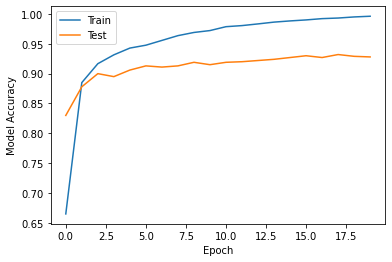

In [5]:
data = MNISTData()
simple_model = Model_without_custom_training_loop(data)
simple_model.build_model()
simple_model.fit_data()
simple_model.plot_score()

x_train, x_test shape (6000, 784) (1000, 784)
y_train, y_test shape (6000, 784) (1000, 784)

Start of epoch 0
Training loss (for one batch) at step 0: 2.2984
Seen so far: 128 samples
Training acc over epoch: 0.1837
Validation acc: 0.2890
Time taken: 1.68s

Start of epoch 1
Training loss (for one batch) at step 0: 2.2698
Seen so far: 128 samples
Training acc over epoch: 0.3407
Validation acc: 0.4070
Time taken: 0.19s

Start of epoch 2
Training loss (for one batch) at step 0: 2.1964
Seen so far: 128 samples
Training acc over epoch: 0.4485
Validation acc: 0.5380
Time taken: 0.20s

Start of epoch 3
Training loss (for one batch) at step 0: 2.1218
Seen so far: 128 samples
Training acc over epoch: 0.5772
Validation acc: 0.6000
Time taken: 0.19s

Start of epoch 4
Training loss (for one batch) at step 0: 1.9919
Seen so far: 128 samples
Training acc over epoch: 0.6562
Validation acc: 0.6380
Time taken: 0.14s

Start of epoch 5
Training loss (for one batch) at step 0: 1.8435
Seen so far: 128 sampl

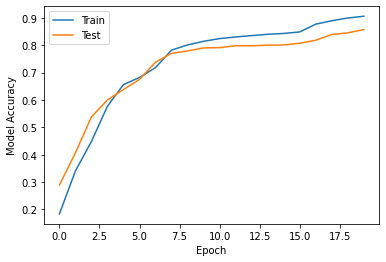

In [6]:
data = MNISTData()
simple_model = Model_with_custom_training_loop(data)
simple_model.build_model()
simple_model.fit_data()
simple_model.plot_score()

The performance of the native Keras method is consistently slightly better, but the training takes approximately the same time (it varies a little bit for both models)!